<a href="https://colab.research.google.com/github/Allenyang2/cs666student/blob/main/Copy_of_CS666_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

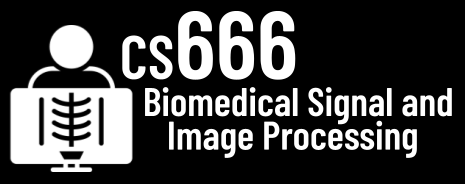
# Assignment 6

In [ ]:
# NAME: Allen Yang

In [4]:
# In this assignment, we will explore the new Segment-Anything-Model (https://segment-anything.com/)
# for the task of mitochondria detection in a connectomics dataset acquired using electron microscopy.
#
# We will run the following experiments:
#
# 1. Using the Segment-Anything-Model (SAM) without seeds in auto mode
#
# 2. Train a U-Net classifier from scratch
#
# 3. Evaluate the U-Net classifier
#
# 4. Use the U-Net to seed the SAM model (U-Net + SAM)
#
# 5. Compare U-Net vs. U-Net + SAM
#
# Bonus: Improve U-Net + SAM

In [5]:
### IMPORTANT (DO THIS RIGHT AWAY!) ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
# We will use mahotas as well!
!pip install mahotas --no-binary :all:
import mahotas as mh

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 68.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: mahotas is being installed using the legacy 'setup.py install' method, because the '--no-binary' option was enabled for it and this currently disables local wheel building for projects that don't have a 'pyproject.toml' file. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussio

In [8]:
# And of course, we need the data!
!wget https://cs666.org/data/mito.npz

--2023-04-24 21:17:43--  https://cs666.org/data/mito.npz
Resolving cs666.org (cs666.org)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to cs666.org (cs666.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37610178 (36M) [application/octet-stream]
Saving to: ‘mito.npz’

mito.npz            100%[===================>]  35.87M  --.-KB/s    in 0.1s    

2023-04-24 21:17:46 (258 MB/s) - ‘mito.npz’ saved [37610178/37610178]



## 0. Data loading (5 points)

In [9]:
# The data includes images and manually segmented masks.
loaded = np.load('mito.npz')
images = loaded['arr_0'][0]
masks = loaded['arr_0'][1]

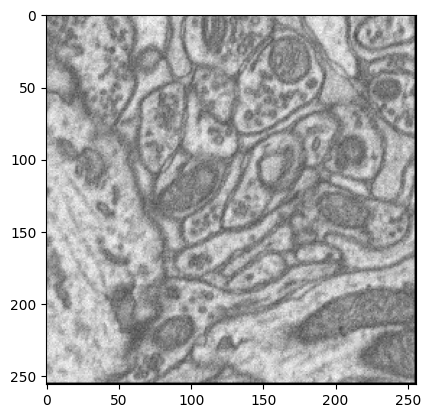

In [10]:
# TODO: Show the first image with the gray colormap.
# TODO: YOUR_CODE

from matplotlib import pyplot as plt

plt.imshow(images[0], cmap = 'gray')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

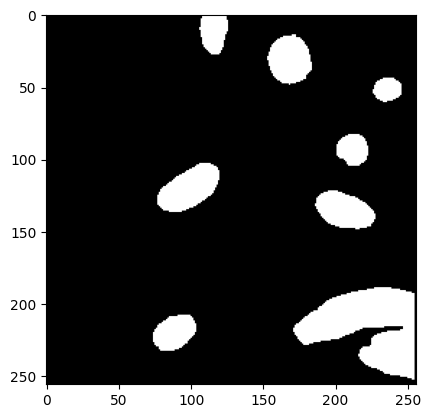

In [11]:
# TODO: Show the first mask.

plt.imshow(masks[0], cmap = 'gray')
plt.show

## 1. SAM in AUTO mode (15 points)

In [12]:
# We will use the METASEG package as an easy-to-use layer
# for SAM.
!pip install metaseg==0.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.2/141.2 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.9 MB/s eta 0:00:00
  Created wheel for metaseg: filename=metaseg-0.6.1-py3-none-any.whl size=44772 sha256=574936c8a56a308f931305a484cc82e228b023a679c29e675de7d225b306dcb9
  Stored in directory: /root/.cache/pip/wheels/b1/0c/bd/5e8d8f9aa755ac2f82e75b9391db0d403f760a4654b19c8b6c
Successfully built metase

In [13]:
# SAM comes in two modes, auto and with seeds
from metaseg import SegAutoMaskPredictor, SegManualMaskPredictor

In [14]:
# SAM takes files as input!
# So we have to store the numpy array to disk.
mh.imsave('first.png', images[0])

In [15]:
#
# Run SAM in auto mode on first.png and store
# the result as first_output.png.
#
results = SegAutoMaskPredictor().image_predict(
    source="first.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="first_output.png",
    show=False,
    save=True,
)

vit_l model has been successfully downloaded and saved as 'vit_l.pth'.


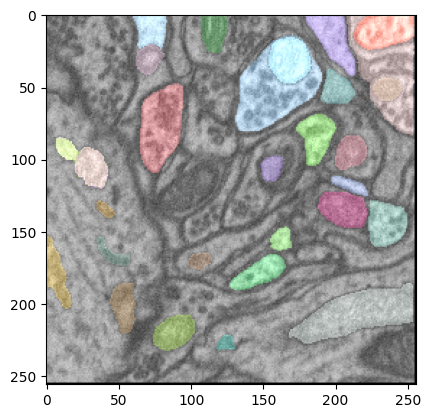

In [16]:
imshow( mh.imread('first_output.png') )

In [17]:
# TODO: Does SAM work well for mitochondria detection?
# TODO: YOUR_ANSWER

#No SAM does not work very well for mitocondria detection. 

In [18]:
# TODO: Try the auto predictor on your image!
# 
# Please upload your own image and test how well
# the auto mode of SAM performs!
#
# Run SAM in auto mode on that image and store
# the result as second_output.png. Show the output!
#

!wget https://thumbs.dreamstime.com/z/transmission-electron-microscope-tem-micrograph-neuron-cell-body-showing-mitochondria-lysosomes-rer-golgi-system-101301067.jpg

results = SegAutoMaskPredictor().image_predict(
    source="transmission-electron-microscope-tem-micrograph-neuron-cell-body-showing-mitochondria-lysosomes-rer-golgi-system-101301067.jpg",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="my_output.png",
    show=False,
    save=True,
)

--2023-04-24 21:18:48--  https://thumbs.dreamstime.com/z/transmission-electron-microscope-tem-micrograph-neuron-cell-body-showing-mitochondria-lysosomes-rer-golgi-system-101301067.jpg
Resolving thumbs.dreamstime.com (thumbs.dreamstime.com)... 192.229.144.114
Connecting to thumbs.dreamstime.com (thumbs.dreamstime.com)|192.229.144.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253112 (247K) [image/jpeg]
Saving to: ‘transmission-electron-microscope-tem-micrograph-neuron-cell-body-showing-mitochondria-lysosomes-rer-golgi-system-101301067.jpg’

transmission-electr 100%[===================>] 247.18K  --.-KB/s    in 0.005s  

2023-04-24 21:18:48 (47.3 MB/s) - ‘transmission-electron-microscope-tem-micrograph-neuron-cell-body-showing-mitochondria-lysosomes-rer-golgi-system-101301067.jpg’ saved [253112/253112]

vit_l model already exists as 'vit_l.pth'. Skipping download.


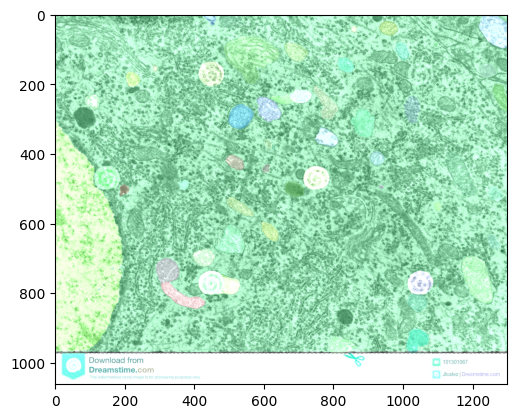

In [19]:
# TODO: YOUR CODE

imshow( mh.imread('my_output.png') )

In [20]:
# TODO: Does SAM work well on your example?
# TODO: YOUR_ANSWER

#Sam works better than the previous example. We can see that there are still some mistakes however less than the previous. 

## 2. Train a U-Net classifier from scratch (50 points)


In [21]:
# We will use the keras_unet package!
#
# HINT: There is documentation available here, if you are stuck during this part
# of the assignment: https://github.com/karolzak/keras-unet
!pip install keras_unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
# keras_unet has convenience functions to visualize data
from keras_unet.utils import plot_imgs

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


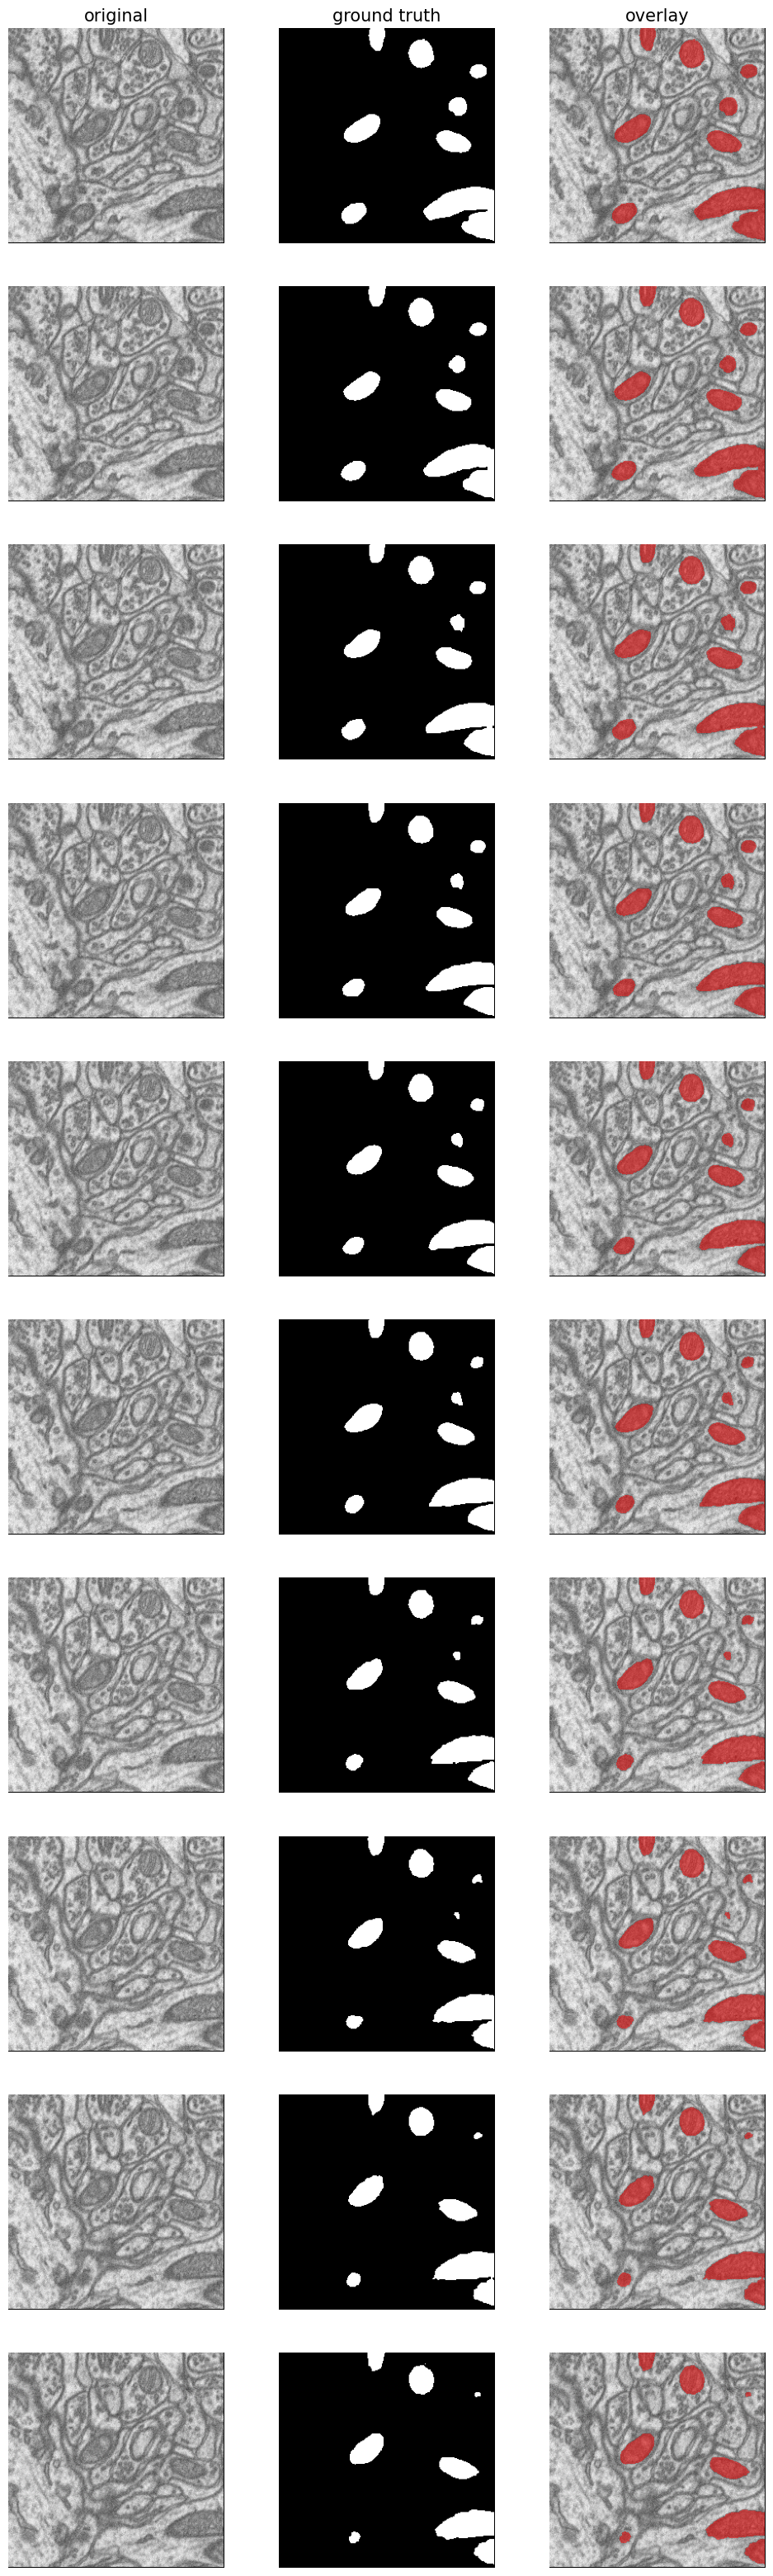

In [23]:
# Let's plot a few images and masks.
plot_imgs(org_imgs=images, mask_imgs=masks)

In [24]:
# The images are in this format.
print( images.shape, images.max(), images.dtype )

(660, 256, 256) 243 uint8


In [52]:
# TODO convert the format to the following:
# (660, 256, 256, 1) 1.0 float32
#
# 1) convert to float32
# 2) normalize to the range of 0..1
# 3) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
# X = 
import numpy as np
X = np.float32(images)
X = X/255
X = np.expand_dims(X, axis = -1)


In [53]:
# Validate that everything matches accordingly
print( X.shape, X.max(), X.dtype )

(660, 256, 256, 1) 0.9529412 float32


In [54]:
# The masks are in this format.
print( masks.shape, masks.max(), masks.dtype )

(660, 256, 256) 255 uint8


In [65]:
# TODO convert the format to the following:
# (660, 256, 256, 1) True bool
#
# 1) convert to bool
# 2) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
# y = 
y = masks.astype(np.bool)
y = np.expand_dims(y,axis = -1)

<ipython-input-65-fe19dfc95afb>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = masks.astype(np.bool)


In [66]:
# Validate that everything matches accordingly
print( y.shape, y.max(), y.dtype )

(660, 256, 256, 1) True bool


In [67]:
#
# Now we will create our train/val/test splits using scikit-learn!
#
from sklearn.model_selection import train_test_split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [69]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [70]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (369, 256, 256, 1)
y_train:  (369, 256, 256, 1)
X_val:  (159, 256, 256, 1)
y_val:  (159, 256, 256, 1)
X_test:  (132, 256, 256, 1)
y_test:  (132, 256, 256, 1)


In [71]:
# TODO: Why do we call train_test_split twice?
# TODO: YOUR_ANSWER

#We call train_test_split twice because we need the train/test set and the validation set.

In [72]:
#
# We will use keras_unet's built-in data augmentation
# functionality.
#
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

In [73]:
# TODO: Please explain the code from above.
# TODO: YOUR_ANSWER

#Train_gen is the variable that will hold the objects for training. The get_augmeted function generates images for training. Each variable within the function is as follows:
#x_train - Training images, y_train - training labels, batch_size - size of the batch of images to train, data_gen_args - dictionary of data containing parameters for the images
#within data_gen_args, the variables are as such:
#rotation_range - degrees of rotation of the image, width_shift_range - random horizontal shift of image, height_shift_range - random vertical shift of image, shear_range - range of shearing of image in degrees, zoom_range - random range of zooming image
# horizontal/vertical_flip - randomly flip the image horizontally or vertically, fill_mode - filling in missing pixels after transformation of image.

(2, 256, 256, 1) (2, 256, 256, 1)


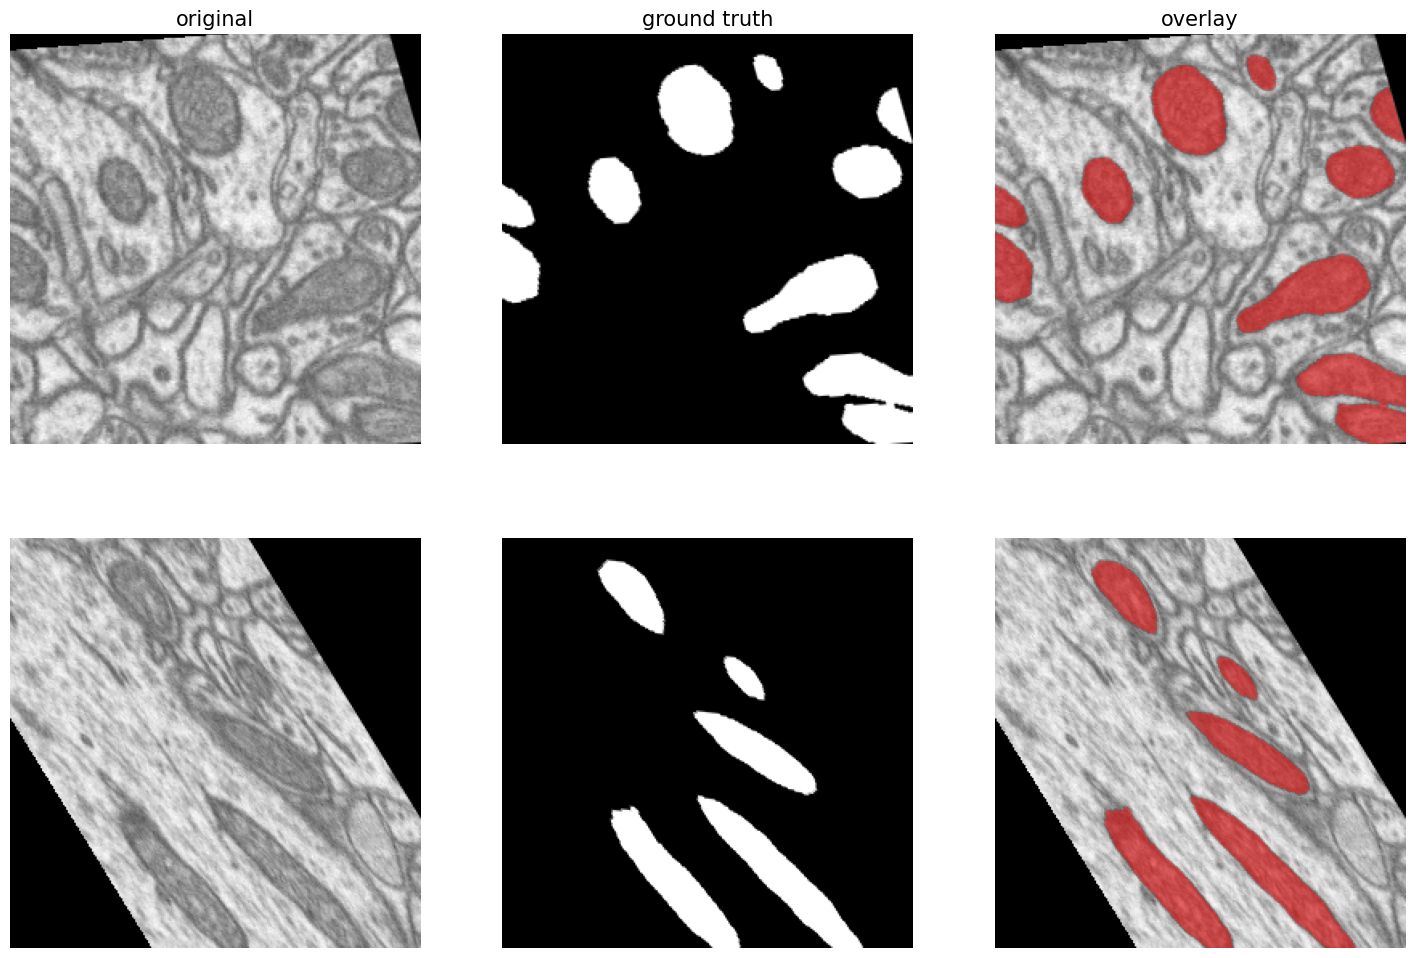

In [74]:
# Run the following code to visualize augmented examples.
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [75]:
#
# Now, we set up a U-Net classifier.
#
from keras_unet.models import custom_unet

model = custom_unet(
    X_train[0].shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [78]:
# TODO: How many  trainable parameters does the model use?
# TODO: YOUR_ANSWER

#We can use the model.summary() to find trainable parameters the model uses. See below for the output!

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 spatial_dropout2d (SpatialDrop  (None, 256, 256, 64  0          ['conv2d[0][0]']                 
 out2D)                         )                                                             

In [79]:
#
# Let's compile the model. Please use a LEARNING_RATE of 0.01
# and a MOMENTUM of 0.99.
#
LEARNING_RATE = 0.01
MOMENTUM = 0.99

In [80]:
#
# We will use Stochastic Gradient Descent as optimizer
# and use IoU as a metric.
#
from keras.optimizers import SGD
from keras_unet.metrics import iou, iou_thresholded

model.compile(
    optimizer=SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [ ]:
# TODO: Please explain Intersect-over-Union (IoU) in just a few sentences.
# TODO: YOUR_ANSWER

#IoU is an evaluation metric used in CV tasks. IoU measures the similarity between two sets of data. It is calculated as the ratio of intersection of the predicted and ground truth datasets. 

In [85]:
#
# Now let's train the model for 30 epochs!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use the train_gen from above as training data.
# Hint 2: Please don't forget (X_val, y_val) as validation data.
# Hint 3: steps_per_epoch should be set to all of the X_train.
# Hint 4: This will take roughly 30 minutes.
# Hint 5: If you are stuck, look through the repo of keras_unet!
#
history = model.fit(
    #
    # TODO: YOUR CODE
    #

    train_gen,
    validation_data = (X_val, y_val),
    steps_per_epoch = len(X_train),
    epochs = 30,
)

Epoch 1/30
369/369 [==============================] - 110s 273ms/step - loss: 0.2222 - iou: 0.0706 - iou_thresholded: 2.0219e-04 - val_loss: 0.1878 - val_iou: 0.1318 - val_iou_thresholded: 6.0699e-06
Epoch 2/30
369/369 [==============================] - 59s 160ms/step - loss: 0.1589 - iou: 0.1674 - iou_thresholded: 0.1209 - val_loss: 0.1413 - val_iou: 0.3010 - val_iou_thresholded: 0.4460
Epoch 3/30
369/369 [==============================] - 58s 157ms/step - loss: 0.1233 - iou: 0.2864 - iou_thresholded: 0.3251 - val_loss: 0.1054 - val_iou: 0.3985 - val_iou_thresholded: 0.4799
Epoch 4/30
369/369 [==============================] - 58s 156ms/step - loss: 0.0914 - iou: 0.4017 - iou_thresholded: 0.4975 - val_loss: 0.0649 - val_iou: 0.6107 - val_iou_thresholded: 0.7219
Epoch 5/30
369/369 [==============================] - 57s 156ms/step - loss: 0.0772 - iou: 0.4848 - iou_thresholded: 0.5961 - val_loss: 0.0724 - val_iou: 0.6768 - val_iou_thresholded: 0.7238
Epoch 6/30
369/369 [================

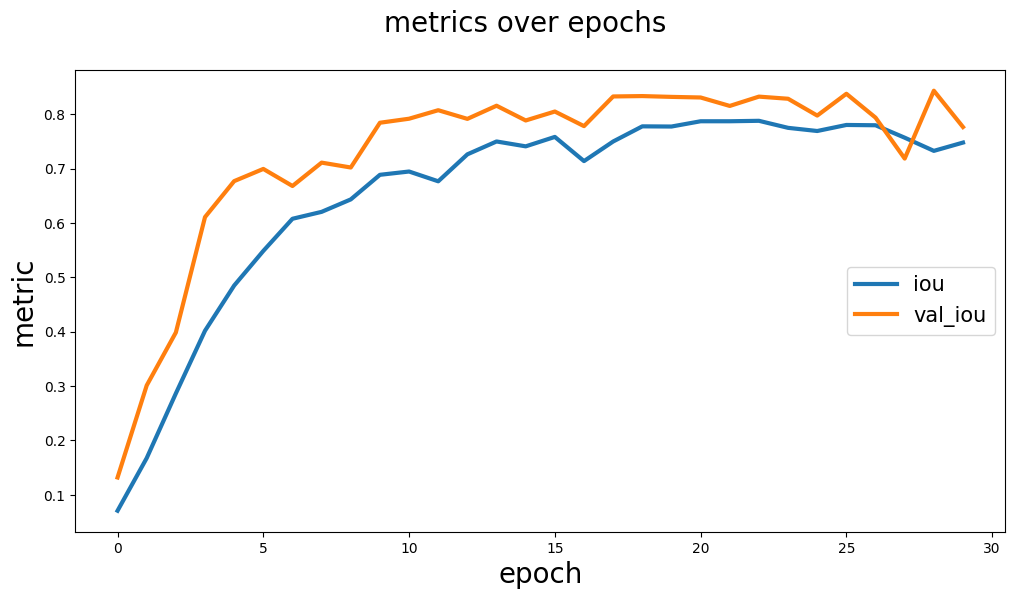

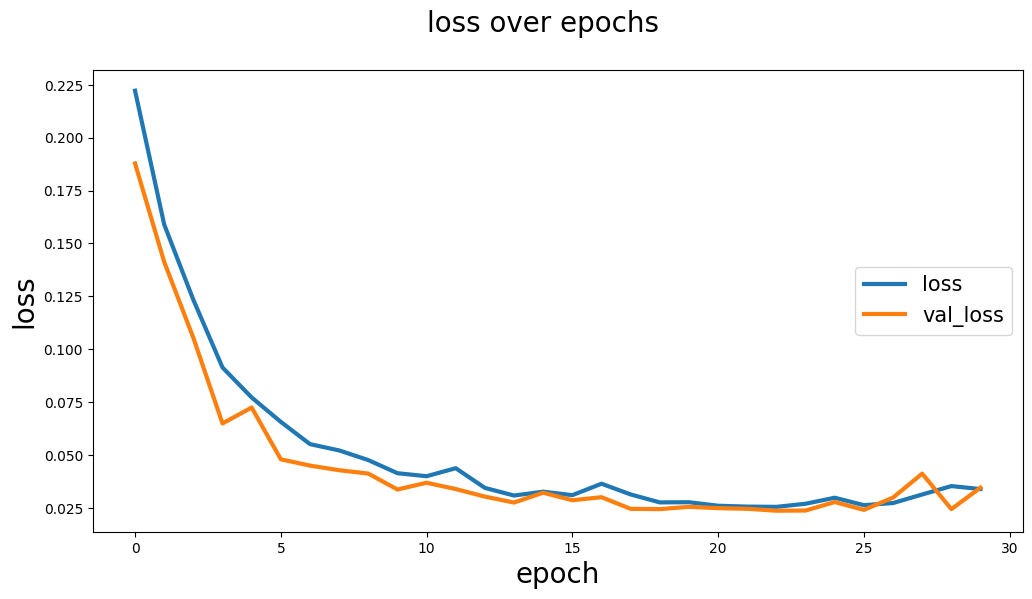

In [87]:
# We can use keras_unet functionality to visualize metrics and loss during training.
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [88]:
# TODO: Do these plots look good to you?
# TODO: YOUR_ANSWER

#Yes, The loss is decreasing per epoch and the IoU increases per epoch which indicates good results.

## 3. Evaluate U-Net (10 points)

In [89]:
# Let's predict all of X_test
y_pred = model.predict(X_test)

5/5 [==============================] - 4s 1s/step


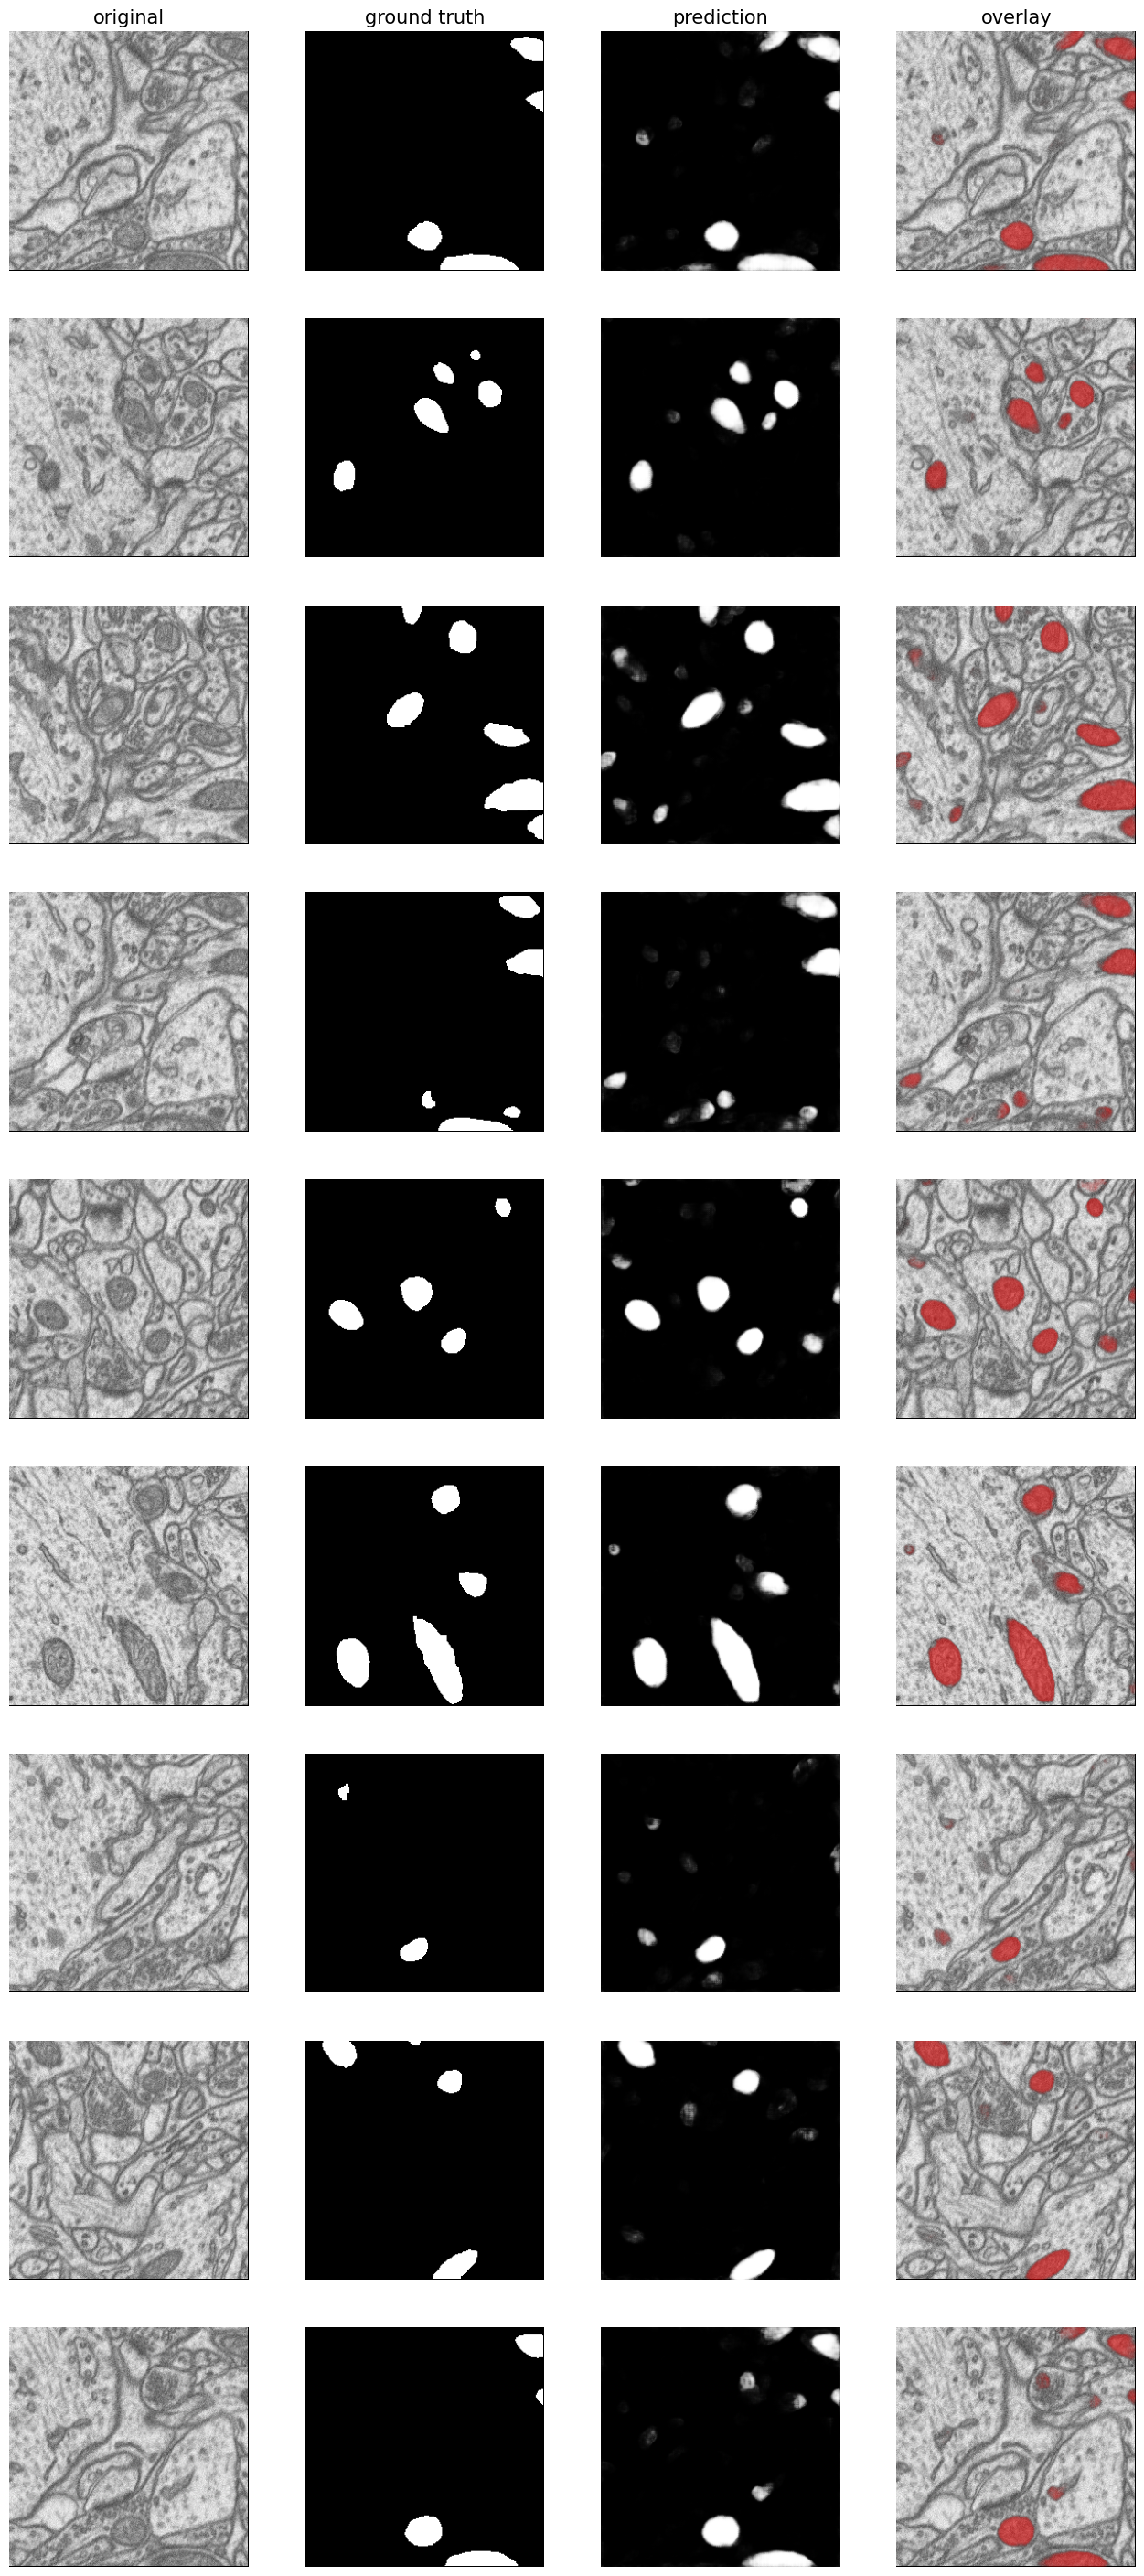

In [90]:
# ...and look at some results.
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=9)

In [91]:
import sklearn.metrics

In [92]:
# Let's use the Jaccard score to compare a thresholded
# y_pred to the groundtruth y_test.
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8416088509526278

In [93]:
# TODO: What is the difference between Jaccard Score and Intersect-over-Union from above?
# TODO: YOUR_ANSWER 
#Jaccard Score is a measure of the overlap that sets A and B share their attributes, its calculated by AnB / AuB. The main difference between is the Jaccard score = (Intersection of predicted and ground-truth sets) / (Union of predicted and ground-truth sets) 
# while the IoU score = (Intersection of predicted and ground-truth bounding boxes/masks) / (Union of predicted and ground-truth bounding boxes/masks)

In [94]:
# TODO: Did the U-Net perform well on X_test?
# TODO: YOUR_ANSWER
#Overall yes, some inaccuracies are still present.

## 4. Combine U-Net with SAM (10 points)

In [95]:
# Instead of running SAM in auto mode without seeds (Task 1), we will now
# use the U-Net predictions on X_test to seed the SAM model.

In [96]:
# We can use the following convenience functions
# to 1) convert mahotas bounding boxes to SAM format
# and 2) combine the SAM output tensors to a mask.

In [97]:
def mahotas_bbox_to_sam(bbs):

  new_bbs = []

  for i,bb in enumerate(bbs):
    # from (y1, y2, x1, x2)
    # to (x1, y1, x2, y2)
    if i == 0:
      continue
    new_bb = [bb[2], bb[0], bb[3], bb[1]]
    new_bbs.append(new_bb)

  return new_bbs

In [98]:
def sam_to_mask(results):

  results = results.cpu() # copy back to cpu land

  mask = np.array(results[0,0])

  for s in results:
    mask[s[0] == 1] = 1

  return mask

In [99]:
# The following code combines the U-Net predictions with SAM.
#
# TODO: Please study the code and answer the TODOs in-line.

In [100]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # TODO: EXPLAIN CODE BELOW
  #convert image from 0-1 to 0-255 and save the image
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  # TODO: EXPLAIN CODE BELOW
  #Using threshold of .5 get the prediction mask of unet. True if softmax is >5 else false.
  pred = (y_pred[z] > 0.5)

  # TODO: EXPLAIN CODE BELOW
  #Label array with connected componenet
  pred, _ = mh.labeled.label(pred)
  
  # TODO: EXPLAIN CODE BELOW
  #bounding boxes
  bbs = mh.labeled.bbox(pred)

  # TODO: EXPLAIN CODE BELOW
  #Convert bounding boxes to Sam format
  bbs_converted = mahotas_bbox_to_sam(bbs)

  # TODO: EXPLAIN CODE BELOW
  #Sam prediciton
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )

  # TODO: EXPLAIN CODE BELOW
  #combine output tensors to a mask
  sam_and_unet_pred = sam_to_mask(results)

  # TODO: EXPLAIN CODE BELOW
  #save the sam prediction
  y_pred_sam[z,:,:,0] = sam_and_unet_pred

vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

## 5. Compare U-Net vs. U-Net+SAM. (10 points)

In [101]:
# U-Net performance on X_test (from Task 3)
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8416088509526278

In [102]:
# U-Net + SAM performance on X_test
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.8093347191623106

In [103]:
# TODO: Please explain the results - is U-Net+SAM a good addition?
# TODO: YOUR_ANSWER
#No, the accuracy drops after applying sam

## Bonus: Improve the results. (33 points)

In [ ]:
# Please improve the results of U-Net+SAM and show the improved Jaccard score.

In [ ]:
# TODO: YOUR_CODE

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#